# Portfolio Optimization using Deep Reinforcement Learning
---

## 6 Backtesting and Evaluation of the Portfolios

### 6.1 Import Relevant Packages

In [26]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pylab as plt
from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat

In [27]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 6.2 Load the Train and Test Data for Portfolios

In [28]:
%store -r max_sharpe_portfolio
%store -r uniform_weights_port

%store -r prices_train_df
%store -r prices_test_df


%store -r a2c_train_daily_return
%store -r ppo_train_daily_return
%store -r ddpg_train_daily_return
%store -r sac_train_daily_return
%store -r td3_train_daily_return

%store -r a2c_test_returns 
%store -r ppo_test_returns 
%store -r ddpg_test_returns 
%store -r sac_test_returns
%store -r td3_test_returns

In [29]:
prices_test_df.head()

,BRITANNIA.NS,AXISBANK.NS,TATASTEEL.NS,HEROMOTOCO.NS,TATACONSUM.NS,HDFCLIFE.NS,GRASIM.NS,JSWSTEEL.NS,BAJAJ-AUTO.NS,NTPC.NS,...,BHARTIARTL.NS,NESTLEIND.NS,APOLLOHOSP.NS,BAJFINANCE.NS,INFY.NS,ONGC.NS,SUNPHARMA.NS,POWERGRID.NS,INDUSINDBK.NS,BAJAJFINSV.NS
date,,,,,,,,,,,,,,,,,,,,,
2023-02-16,4617.899902,874.299988,112.199997,2590.000000,735.500000,522.000000,1636.194092,731.450012,3930.949951,167.699997,...,790.500000,1979.984985,4668.000000,6524.750000,1614.449951,156.449997,1010.000000,162.675003,1156.099976,1435.000000
2023-02-17,4588.000000,868.250000,113.099998,2539.100098,734.799988,514.549988,1662.190796,735.900024,3920.000000,169.649994,...,787.450012,1957.505005,4668.950195,6475.799805,1595.000000,158.800003,996.500000,161.925003,1143.900024,1427.199951
2023-02-20,4545.000000,861.200012,112.699997,2544.500000,729.450012,522.750000,1643.764038,733.000000,3934.949951,170.000000,...,793.799988,1914.500000,4649.950195,6443.549805,1603.000000,157.800003,991.650024,162.750000,1122.800049,1425.800049
2023-02-21,4527.850098,849.000000,114.199997,2545.000000,730.000000,514.799988,1652.329956,736.000000,3927.000000,174.250000,...,788.000000,1893.380005,4640.000000,6408.250000,1601.650024,155.899994,990.799988,164.062500,1112.150024,1409.400024
2023-02-22,4540.899902,843.000000,113.699997,2534.649902,734.000000,501.750000,1627.777588,723.250000,3890.250000,173.199997,...,781.650024,1888.280029,4535.950195,6360.000000,1575.000000,154.500000,978.000000,162.975006,1096.949951,1392.000000


In [30]:
returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()

# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_returns = returns_train.dot(uw_weights)
uw_cum_returns = (1 + uw_returns).cumprod()
uw_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_returns = returns_train.dot(max_sharpe_weights)
max_sharpe_cum_returns = (1 + max_sharpe_returns).cumprod()
max_sharpe_cum_returns.name = "portfolio 2: max sharpe"

a2c_train_cum_returns = (1 + a2c_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns = a2c_train_cum_returns['daily_return']
a2c_train_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_train_cum_returns = (1 + ppo_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns = ppo_train_cum_returns['daily_return']
ppo_train_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_train_cum_returns = (1 + ddpg_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns = ddpg_train_cum_returns['daily_return']
ddpg_train_cum_returns.name = 'Portfolio 5: ddpg Model'

sac_train_cum_returns = (1 + sac_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns = sac_train_cum_returns['daily_return']
sac_train_cum_returns.name = 'Portfolio 6: sac Model'

td3_train_cum_returns = (1 + td3_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns = td3_train_cum_returns['daily_return']
td3_train_cum_returns.name = 'Portfolio 7: td3 Model'


date_list = list(td3_train_cum_returns.index)

max_sharpe_cum_returns = max_sharpe_cum_returns[(max_sharpe_cum_returns.index).isin (date_list)]
uw_cum_returns = uw_cum_returns[(uw_cum_returns.index).isin (date_list)]


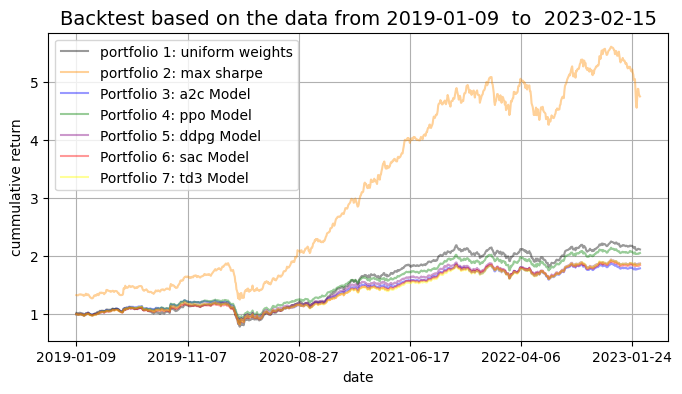

In [31]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(8,4))
uw_cum_returns.plot(ax=ax, color="black", alpha=0.4);
max_sharpe_cum_returns.plot(ax=ax, color="darkorange", alpha=0.4);

a2c_train_cum_returns.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns.plot(ax=ax, color='purple', alpha=0.4)
sac_train_cum_returns.plot(ax=ax, color='red', alpha=0.4)
td3_train_cum_returns.plot(ax=ax, color='yellow', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2019-01-09  to  2023-02-15", fontsize=14);
fig.savefig('results/back_test_on_train_data.png');

### 6.4 Evaluating the Portfolios on Test Data

In [32]:
# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_cum_returns = (1 + uw_test_returns).cumprod()
uw_test_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_cum_returns = (1 + max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "portfolio 2: max sharpe"

a2c_test_cum_returns = (1 + a2c_test_returns['daily_return']).cumprod()
a2c_test_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_test_cum_returns = (1 + ppo_test_returns['daily_return']).cumprod()
ppo_test_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_test_cum_returns = (1 + ddpg_test_returns['daily_return']).cumprod()
ddpg_test_cum_returns.name = 'Portfolio 5: ddpg Model'

sac_test_cum_returns = (1 + sac_test_returns['daily_return']).cumprod()
sac_test_cum_returns.name = 'Portfolio 6: sac Model'

td3_test_cum_returns = (1 + td3_test_returns['daily_return']).cumprod()
td3_test_cum_returns.name = 'Portfolio 7: td3 Model'

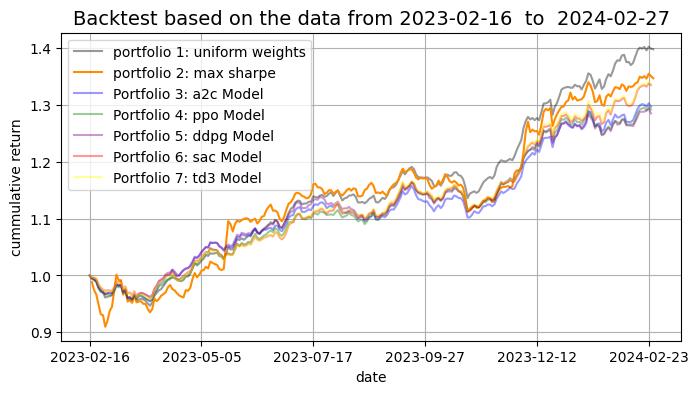

In [33]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(8,4))
uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns.plot(ax=ax, color='purple', alpha=.4)
sac_test_cum_returns.plot(ax=ax, color='red', alpha=.4)
td3_test_cum_returns.plot(ax=ax, color='yellow', alpha=.4)
plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2023-02-16  to  2024-02-27", fontsize=14);
fig.savefig('results/back_test_on_test_data.png');

### 6.5 Get the Portfolio Statistics

In [34]:
# Define a Function for Getting the Portfolio Statistics

def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date','daily_return']
    
    #Use the FinRL Library to get the Portfolio Returns
    #This makes use of the Pyfolio Library
    
    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                  factor_returns=DRL_strat, 
                                    positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame( perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [35]:
uw_test_returns.shape

(253,)

In [36]:
# Get the Portfolio Statistics for all the portfolios
portfolios_returns_dict = {'uniform_weights':uw_test_returns, 'maximum_sharpe':max_sharpe_test_returns,
                          'a2c Model': a2c_test_returns['daily_return'],
                          'ppo Model': ppo_test_returns['daily_return'],
                          'ddpg Model': ddpg_test_returns['daily_return'],
                          'sac Model': sac_test_returns['daily_return'],
                          'td3 Model': td3_test_returns['daily_return']}

portfolios_stats = pd.DataFrame()
for i,j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [37]:
portfolios_stats

,uniform_weights,maximum_sharpe,a2c Model,ppo Model,ddpg Model,sac Model,td3 Model
Annual return,0.395850,0.345176,0.296812,0.291876,0.285003,0.334938,0.336284
Cumulative returns,0.397699,0.346760,0.296812,0.291876,0.285003,0.334938,0.336284
Annual volatility,0.088457,0.139886,0.083850,0.081617,0.081116,0.085688,0.085852
Sharpe ratio,3.831826,2.198734,3.143046,3.179999,3.133354,3.415967,3.421345
Calmar ratio,7.451223,3.832195,6.170489,6.565170,6.423760,7.563902,7.477094
Stability,0.951707,0.891595,0.916249,0.945891,0.927873,0.945589,0.945963
Max drawdown,-0.053126,-0.090073,-0.048102,-0.044458,-0.044367,-0.044281,-0.044975
Omega ratio,1.855025,1.495237,1.653566,1.654359,1.653597,1.744383,1.748570
Sortino ratio,6.007955,3.702730,4.950354,5.050111,4.884287,5.503344,5.522838
Skew,NaN,NaN,-0.303569,-0.336913,-0.441488,-0.241108,-0.233333


### 6.6 Benchmarking the Best Portfolio against the Benchmark Index

In [38]:
#a2c_test_returns = a2c_test_returns.set_index('date')
ppo_test_returns = ppo_test_returns.set_index('date')
ddpg_test_returns = ddpg_test_returns.set_index('date')
sac_test_returns = sac_test_returns.set_index('date')
td3_test_returns = td3_test_returns.set_index('date')

In [39]:
a2c_test_returns.head()

,date,daily_return
0,2023-02-16,0.000000
1,2023-02-17,-0.005276
2,2023-02-20,-0.001997
3,2023-02-21,-0.003438
4,2023-02-22,-0.010396


In [40]:
# Getting the best performing portfolio

ps_cum = [a2c_test_cum_returns, ppo_test_cum_returns,ddpg_test_cum_returns, sac_test_cum_returns, td3_test_cum_returns]
ps = [a2c_test_returns['daily_return'], ppo_test_returns['daily_return'], ddpg_test_returns['daily_return'], sac_test_returns['daily_return'], td3_test_returns['daily_return']]

final_return = []
for p in ps_cum:
    final_return.append(p.iloc[-1])
    
id_ = np.argmax(final_return)
best_p = ps[id_]
best_p.name = (ps_cum[id_]).name 

print("Best portfolio: ",  best_p.name)
print("Final cumulative return: {:.2f} ".format(final_return[id_]))

Best portfolio:  Portfolio 7: td3 Model
Final cumulative return: 1.34 


In [41]:
# convert the best portfolio into a Dataframe

best_p = pd.DataFrame(best_p)
best_p = best_p.reset_index()
best_p.columns=['date','daily_return']
best_p['date'] = a2c_test_returns['date']

In [42]:
best_p.head()

,date,daily_return
0,2023-02-16,0.000000
1,2023-02-17,-0.003327
2,2023-02-20,-0.000918
3,2023-02-21,-0.001470
4,2023-02-22,-0.010038


In [43]:
# Best portfolio stats
best_port_strat = backtest_strat(best_p)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=best_port_strat, 
                              factor_returns=best_port_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [44]:
prices_test_dates = list(prices_test_df.index)

print("==============Get Index Stats===========")
baesline_perf_stats=BaselineStats('^NSEI',
                                  baseline_start = prices_test_dates[0],
                                  baseline_end = prices_test_dates[-1])

[*********************100%%**********************]  1 of 1 completed

==============Get Index Stats===========
Shape of DataFrame:  (252, 8)
Annual return          0.226560
Cumulative returns     0.226560
Annual volatility      0.101163
Sharpe ratio           2.077923
Calmar ratio           3.426544
Stability              0.894166
Max drawdown          -0.066119
Omega ratio            1.388652
Sortino ratio          3.129731
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.016811
Daily value at risk   -0.011911
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [45]:
nsei, dow_strat = baseline_strat('^NSEI',prices_test_dates[1], prices_test_dates[-1])

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)


In [46]:
import pyfolio
print(pyfolio.__version__)

0.9.5


In [47]:
pip install --upgrade pyfolio-reloaded


Note: you may need to restart the kernel to use updated packages.


Start date,2023-02-17
End date,2024-02-26
Total months,11
,Backtest
Annual return,33.783%
Cumulative returns,33.628%
Annual volatility,8.602%
Sharpe ratio,3.43
Calmar ratio,7.51
Stability,0.95
Max drawdown,-4.498%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.50,2023-09-18,2023-10-26,2023-11-23,49
1,3.82,2023-02-17,2023-03-28,2023-04-11,38
2,2.78,2024-01-15,2024-01-24,2024-02-02,15
3,2.47,2023-08-01,2023-08-18,2023-09-04,25
4,1.75,2023-12-20,2023-12-21,2023-12-27,6


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyfolio/plotting.py:1373: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.boxplot(


UnboundLocalError: local variable 'boxprops' referenced before assignment

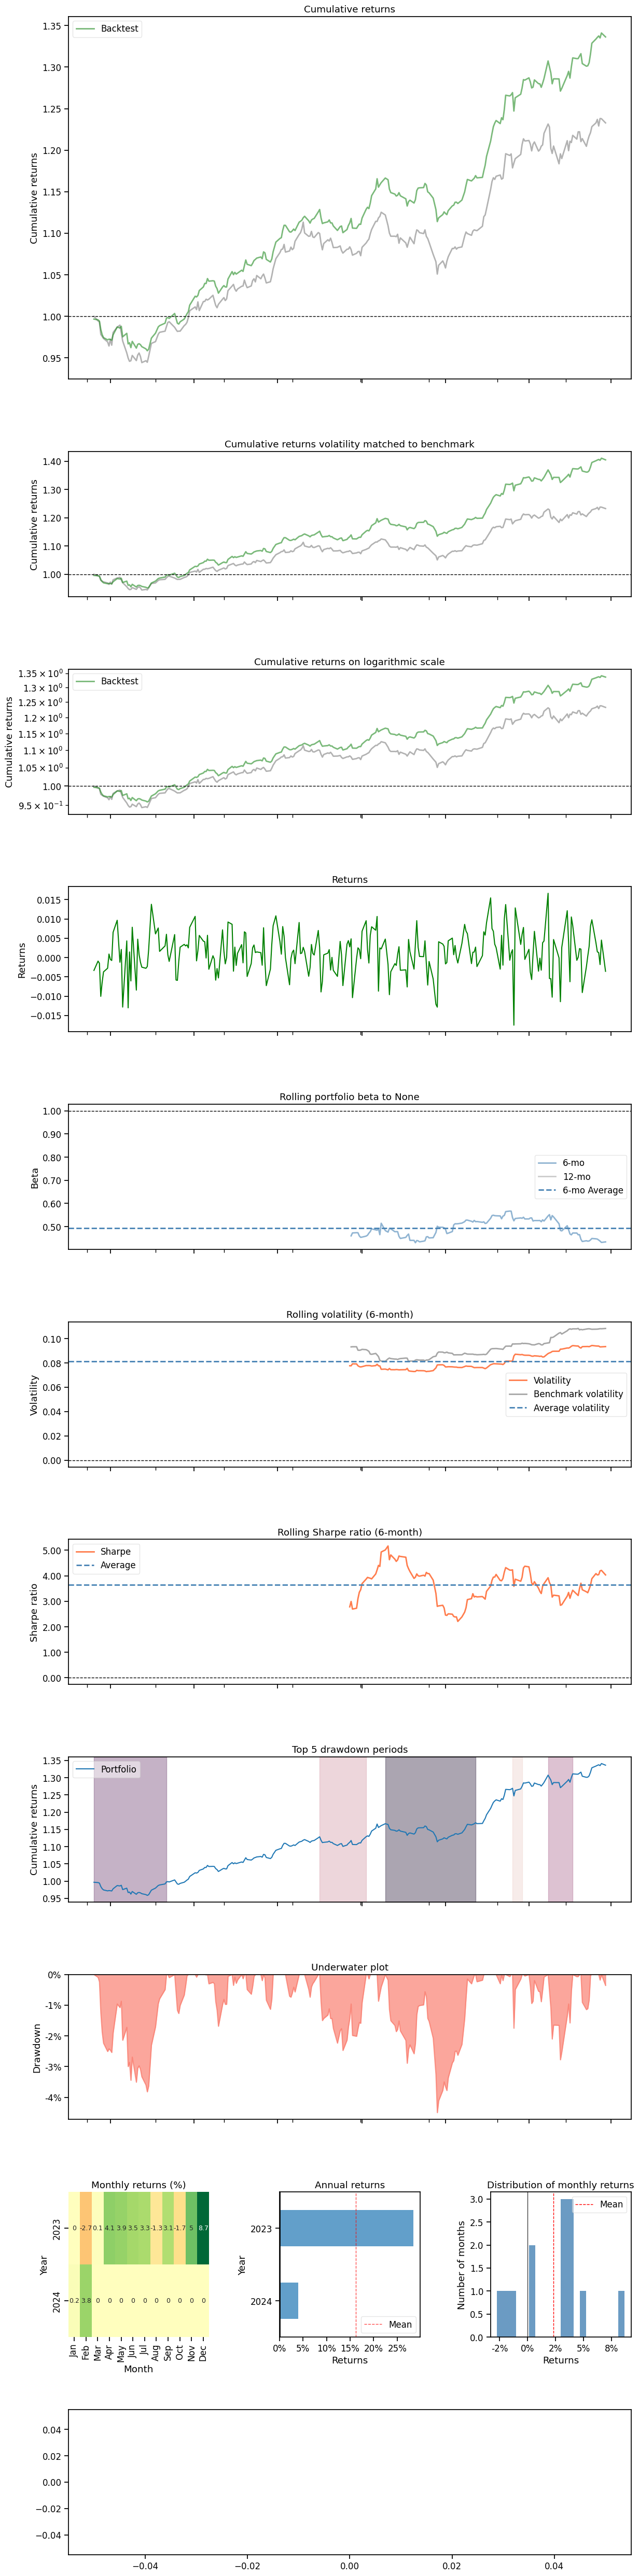

In [48]:
# Get the Benchmarking Plots
import pyfolio
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = best_port_strat,
                                       benchmark_rets=dow_strat, set_context=False)